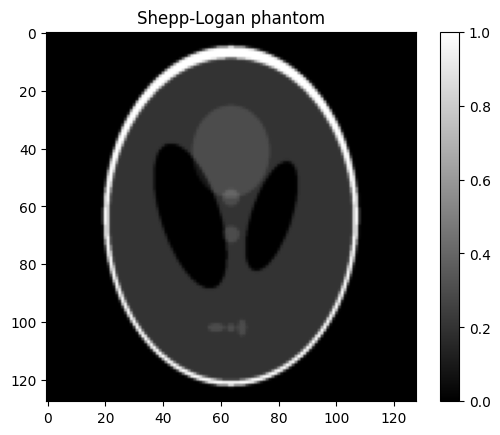

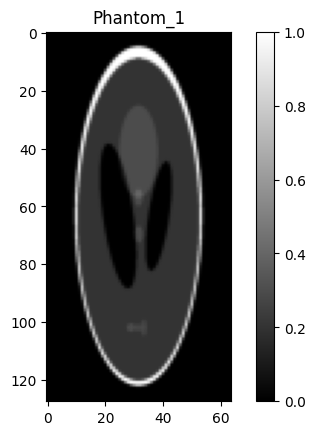

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.fft import fftshift, fft2, ifft2
from skimage.data import shepp_logan_phantom # type: ignore
from skimage.transform import resize
import pandas as pd
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import lsqr

# Re-generate and resize Shepp-Logan phantom
N_spinsx = 128  # Number of spins in each direction
N_spinsy = 128  # Number of spins in each direction
phantom = shepp_logan_phantom()
phantom = resize(phantom, (N_spinsx, N_spinsy))

# Plot Shepp-Logan phantom
plt.imshow(np.abs(phantom), cmap='gray')
plt.title('Shepp-Logan phantom')
plt.colorbar()
plt.show()


# K-space size
Nx = 128
Ny = 64

phantom_1 = resize(phantom, (Nx, Ny))

phantom = phantom.astype(dtype=np.complex128)
phantom_1 = phantom_1.astype(dtype=np.complex128)


# Plot the phantom_1
plt.imshow(np.abs(phantom_1), cmap='gray')
plt.title('Phantom_1')
plt.colorbar()
plt.show()




gamma = 42.58e6  # Gyromagnetic ratio for hydrogen in Hz/T
g_mult = 10 # Gradient multiplication factor
Gx = 0.004755753 * g_mult  # Gradient strength in T/m
Gy = 0.004755753 * g_mult # Gradient strength in T/m
#B0 = 1.0  # B0 field in T

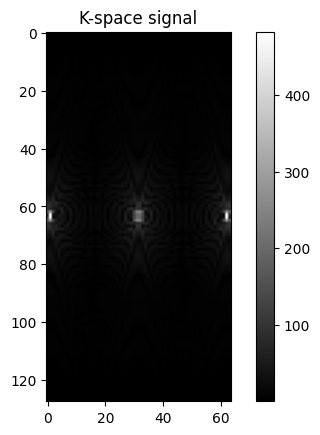

In [2]:
# Field of view
FOV = 0.2  # meters

# Time intervals for the gradients
tau = 2e-3
timex = np.linspace(-tau/2, tau/2, Nx)
timey = np.linspace(-tau/2, tau/2, Ny)

# Gradient fields
Gx_values = timex * Gx
Gy_values = timey * Gy

# k-space trajectory (spatial frequencies)
kx_values = gamma * Gx_values
ky_values = gamma * Gy_values

# Spatial coordinates
x_values = np.linspace(-FOV / 2, FOV / 2, Nx)
y_values = np.linspace(-FOV / 2, FOV / 2, Ny)
x_values, y_values = np.meshgrid(x_values, y_values, indexing='ij')


# Compute k-space values
k_space = np.zeros((Nx, Ny), dtype=np.complex128)
for i, kx in enumerate(kx_values):
    for j, ky in enumerate(ky_values):
        k_space[i, j] = np.sum(phantom_1 * np.exp(-1j * (kx * x_values + ky * y_values)))

# Plot the absolute k-space signal
plt.figure()
plt.imshow(np.abs(k_space), cmap='gray')
plt.title('K-space signal')
plt.colorbar()
plt.show()

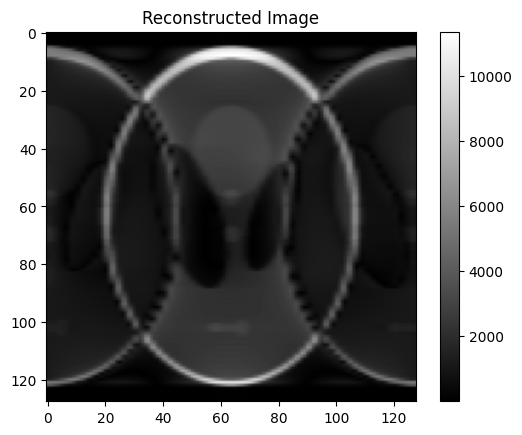

In [3]:
x_values_1 = np.linspace(-FOV / 2, FOV / 2, Nx)
y_values_1 = np.linspace(-FOV / 2, FOV / 2, Ny)


def inverse_fourier_2d(k_space):
    # Allocate a space for the output image
    image = np.zeros((Nx, Ny), dtype=np.complex128)

    # Create a grid of k-space indices
    i_values, j_values = np.meshgrid(np.arange(Nx), np.arange(Ny), indexing='ij')

    # Iterate through each pixel in k-space
    for m in range(Nx):
        for n in range(Ny):
            # Calculate the inverse Fourier transform using vectorized operations
            image[m, n] = np.sum(k_space * np.exp(1j * (kx_values[i_values] * x_values_1[m] + ky_values[j_values] * y_values_1[n])))

    return image


# Apply the inverse Fourier transform to the k-space data
reconstructed_image = inverse_fourier_2d(k_space)


reconstructed_image = resize(np.abs(reconstructed_image), (128, 128))


# Plot the absolute value of the reconstructed image
plt.figure()
plt.imshow(reconstructed_image, cmap='gray')
plt.colorbar()
plt.title('Reconstructed Image')
plt.show()
